In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import scipy.stats as stats
import random
import numpy as np
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
def compute_chi(data):
    '''
    Computes the value of Chi, a synchrony measurement that compares the variance of individual voltage traces and the variance of the mean of the voltages.

    Parameters:
        data (list[float]):
            Voltage traces with each row corresponding one neuron.

    Returns:
        chi (float):
            The value of Chi.
    '''

    #calculate the average voltage as a function of time
    mean_voltage = np.mean(data,axis=0)

    #calculate the variance of each trave and the average voltage
    ind_variance = np.mean(np.square(data),axis=1) - np.mean(data,axis=1)**2
    total_variance = np.mean(np.square(mean_voltage)) - np.mean(mean_voltage)**2

    #calculate chi
    chi = np.sqrt(total_variance**2 / np.mean(ind_variance**2))

    return chi 


In [5]:
def compute_chi(data):
    '''
    Computes the value of Chi, a synchrony measurement that compares the variance of individual voltage traces and the variance of the mean of the voltages.

    Parameters:
        data (list[float]):
            Voltage traces with each row corresponding one neuron.

    Returns:
        chi (float):
            The value of Chi.
    '''

    #calculate the average voltage as a function of time
    mean_voltage = np.mean(data,axis=0)

    #calculate the variance of each trave and the average voltage
    ind_variance = np.mean(np.square(data),axis=1) - np.mean(data,axis=1)**2
    total_variance = np.mean(np.square(mean_voltage)) - np.mean(mean_voltage)**2

    #calculate chi
    chi = np.sqrt(total_variance**2 / np.mean(ind_variance**2))

    return chi 


# Sparse Network Colour Plots

findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.


Average number of connections per neuron: 39.596666666666664
Connectivity Matrix g [[0.   0.03 0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.03 0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.   0.03 0.   ... 0.   0.   0.03]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.03 0.  ]]
Average value of matrix g= 0.003959666666666666
Chi measure (synchrony): 0.3376599271913788
Average firing rate 16.766666666666666


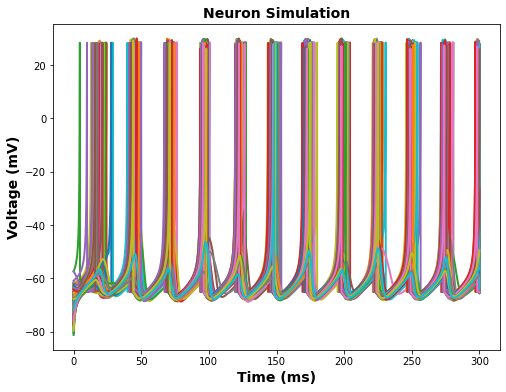

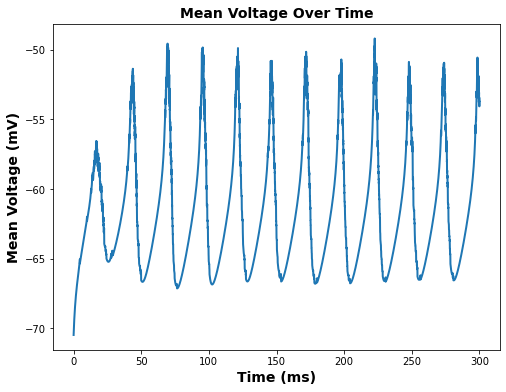

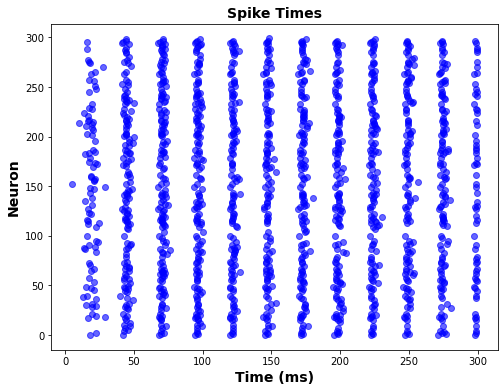

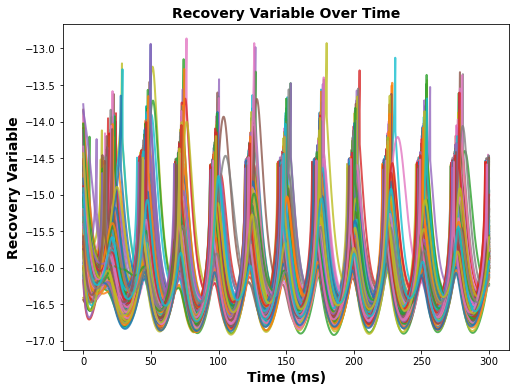

In [6]:
np.random.seed(101)

N = 300
T = 300
M = 50000
dt = 0.005
t0 = 0

k = 1
a = 0.1
b = 0.26
c = -65
d = -1
v_reset = c
v_thresh = 30

Esyn = -70
tauS = 3.043043043043043 # Obtained from having peaks of coupling in paper and in ours aligned

J = np.random.normal(0, 0.1, size=(N))


I = 0.6

# Define desired average number of connections
Avg_Connections = 40
connection_probability = Avg_Connections / N

# Initialize the synaptic coupling matrix
g = np.zeros((N, N))

# # Sparsely connected networks with probabilistic connections
for j in range(N):
    for i in range(N):
        if i != j:  # Avoid self-connections
            if np.random.rand() < connection_probability:
                g[j, i] = 0.03  # Set connection strength 



# Set the diagonal elements to zero
np.fill_diagonal(g, 0)

v_init = np.random.normal(-70, 5, size=(N))
u_init = np.random.normal(-15, 0.5, size = (N)) # Ask any reason why these were chosen and not ones in page 3 paper
s_init = np.zeros(N)
p_init = np.zeros(N)

t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init, s_init, p_init])
y_all = np.reshape(y_0, (y_0.shape[0], 1))

spike_times = np.zeros((M, 2))
spikeCounter = 0
i = 0

def dxdt(t, x, k, a, b, I, Esyn, J, tauS):
    v = x[:N]
    u = x[N:2*N]
    s = x[2*N:3*N]
    p = x[3*N:4*N]
    
    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) + J - (v - Esyn) * np.dot(g,s)
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS + p / tauS
    dpdt = -p / tauS
    
    return np.concatenate([dvdt, dudt, dsdt, dpdt])

# Spike event
def v_spike(t, x, k, a, b, I, Esyn, J, tauS):
    return x[:N].max() - v_thresh
v_spike.terminal = True
v_spike.direction = 1

# Set up spike time vector
spike_times = np.zeros((M, 2))
spikeCounter = 0    
i = 0

# Simulation loop
while i < M and t0 < T:
    y0 = np.concatenate([v_init, u_init, s_init, p_init])  
   
    sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                      events=v_spike, rtol=1e-8)
    
    t_end = sol_v.t[-1]
    steps = max([2, int((t_end - t0) / dt)])
    t = np.linspace(t0, t_end, steps)
    y = sol_v.sol(t)
    
    t_all = np.concatenate([t_all, t[:-1]], axis=0)
    y_all = np.concatenate([y_all, y[:, :-1]], axis=1)
    
    t0 = t_end
    v_init = y[:N, -1]
    u_init = y[N:2*N, -1]
    s_init = y[2*N:3*N, -1]
    p_init = y[3*N:4*N, -1]
    
    if len(sol_v.t_events[0]) > 0:
        spike = v_init.argmax()
        v_init[spike] = v_reset
        u_init[spike] += d
        p_init[spike] += (2.7185823035951033)/(tauS/3.043043043043043) #x0 
        
        
        spike_times[spikeCounter, :] = [t0, spike]
        spikeCounter = spikeCounter + 1
        i += 1

colours = sns.color_palette('deep')
font = {'family': 'Times', 'weight': 'normal', 'size': 18}
plt.rc('font', **font)

# Plot 1: Neuron Simulation
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[:N, :].T, linewidth=2)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Voltage (mV)', fontsize=14, fontweight='bold')
plt.title('Neuron Simulation', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('NeuronModel_A2A.png')

# Plot 2: Mean Voltage Over Time
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[:N, :].mean(axis=0), linewidth=2)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Mean Voltage (mV)', fontsize=14, fontweight='bold')
plt.title('Mean Voltage Over Time', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig('MeanVoltage_A2A.png')

# Plot 3: Spike Times Scatter Plot
spike_times = spike_times[:spikeCounter, :]
plt.figure(figsize=(8, 6))
plt.scatter(spike_times[:, 0], spike_times[:, 1], color='blue', alpha=0.6)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Neuron', fontsize=14, fontweight='bold')
plt.title('Spike Times', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig('SpikeTimes_A2A.png')

# Plot 4: Recovery Variable
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[N:2*N, :].T, linewidth=2, alpha=0.8)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Recovery Variable', fontsize=14, fontweight='bold')
plt.title('Recovery Variable Over Time', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig('RecoveryVariable_A2A.png')




# Count the number of non-zero entries in each row
connections_per_neuron = np.count_nonzero(g, axis=1)

# Calculate the average number of connections per neuron
average_connections = np.mean(connections_per_neuron)

print(f"Average number of connections per neuron: {average_connections}")
print("Connectivity Matrix g", g)
print("Average value of matrix g=", np.mean(g))
# Extract the voltage traces (first N rows of y_all)
voltage_data = y_all[:N, :]  # Shape: (N, time_steps)

# Compute the Chi measure
chi_value = compute_chi(voltage_data)

# Print the Chi measure
print(f"Chi measure (synchrony): {chi_value}")


average_firing_rate = len(spike_times[spike_times[:, 0] > 100]) / (N * (T - 100))*1000
print("Average firing rate", average_firing_rate)

# $\chi^2$ Colour Plot

In [7]:
g_syn_values = np.linspace(0.005, 0.1, 20)  
print(g_syn_values)
tau_s_values = np.linspace(0.25, 5, 20)
print(tau_s_values)

[0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.06
 0.065 0.07  0.075 0.08  0.085 0.09  0.095 0.1  ]
[0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25 3.5
 3.75 4.   4.25 4.5  4.75 5.  ]


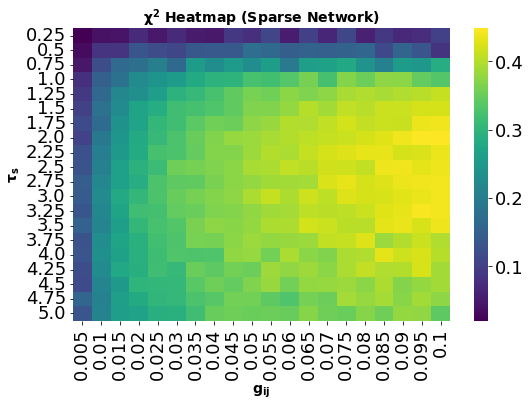

In [17]:
# Create results directory
os.makedirs("results", exist_ok=True)

# Define parameter grid
tau_s_values = np.linspace(0.25, 5, 20)
g_syn_values = np.linspace(0.005, 0.1, 20)
chi_sq_matrix = np.zeros((len(tau_s_values), len(g_syn_values)))

# Try to load existing progress
progress_path = "results/progress.json"
matrix_path = "results/chi_sq_matrix.npy"

completed = []
if os.path.exists(progress_path):
    with open(progress_path, "r") as f:
        completed = json.load(f)

if os.path.exists(matrix_path):
    chi_sq_matrix = np.load(matrix_path)

# Main computation loop
for i, tau_s in enumerate(tau_s_values):
    for j, g_syn in enumerate(g_syn_values):
        if [i, j] in completed:
            continue  # Skip already completed

        # === Begin your simulation setup ===
        g = np.zeros((N, N))
        for row in range(N):
            for col in range(N):
                if row != col and np.random.rand() < connection_probability:
                    g[row, col] = g_syn

        v_init = np.random.normal(-70, 15, size=(N))
        u_init = np.random.normal(-15, 0.5, size=(N))
        s_init = np.zeros(N)
        p_init = np.zeros(N)

        t_all = np.array([t0])
        y_0 = np.concatenate([v_init, u_init, s_init, p_init])
        y_all = np.reshape(y_0, (y_0.shape[0], 1))

        spike_times = np.zeros((M, 2))
        spikeCounter = 0
        t0 = 0
        i_step = 0

        while i_step < M and t0 < T:
            y0 = np.concatenate([v_init, u_init, s_init, p_init])
            sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tau_s),
                              dense_output=True, events=v_spike, rtol=1e-8)

            t_end = sol_v.t[-1]
            steps = max([2, int((t_end - t0) / dt)])
            t = np.linspace(t0, t_end, steps)
            y = sol_v.sol(t)

            t_all = np.concatenate([t_all, t[:-1]], axis=0)
            y_all = np.concatenate([y_all, y[:, :-1]], axis=1)

            t0 = t_end
            v_init = y[:N, -1]
            u_init = y[N:2*N, -1]
            s_init = y[2*N:3*N, -1]
            p_init = y[3*N:4*N, -1]

            if len(sol_v.t_events[0]) > 0:
                spike = v_init.argmax()
                v_init[spike] = v_reset
                u_init[spike] += d
                p_init[spike] += (2.7185823035951033)/(tau_s/3.043043043043043)

                spike_times[spikeCounter, :] = [t0, spike]
                spikeCounter += 1
                i_step += 1

        # === End simulation ===

        data = y_all[:N, :]
        chi_sq = compute_chi(data)
        chi_sq_matrix[i, j] = chi_sq

        # Save partial result
        np.save(matrix_path, chi_sq_matrix)

        # Optional: save data for debugging/analysis
        np.savez(f"results/sim_{i}_{j}.npz", t_all=t_all, y_all=y_all, spike_times=spike_times)

        # Log progress
        completed.append([i, j])
        with open(progress_path, "w") as f:
            json.dump(completed, f)

# === Plot after loop finishes ===
plt.figure(figsize=(8, 6))
sns.heatmap(chi_sq_matrix, xticklabels=np.round(g_syn_values, 3), yticklabels=np.round(tau_s_values, 2), cmap='viridis')
plt.xlabel(r'$\mathbf{g_{ij}}$', fontsize=14, fontweight='bold')
plt.ylabel(r'$\mathbf{\tau_s}$', fontsize=14, fontweight='bold')
plt.title(r'$\mathbf{\chi^2}$ Heatmap (Sparse Network)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('Chi_Sparse.png')
plt.show()


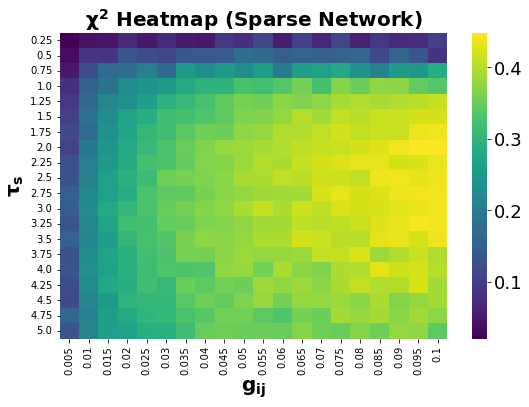

In [22]:
plt.figure(figsize=(8, 6))
sns.heatmap(chi_sq_matrix, xticklabels=np.round(g_syn_values, 3), yticklabels=np.round(tau_s_values, 2), cmap='viridis')
plt.xlabel(r'$\mathbf{g_{ij}}$', fontsize=20, fontweight='bold')
plt.ylabel(r'$\mathbf{\tau_s}$', fontsize=20, fontweight='bold')
plt.title(r'$\mathbf{\chi^2}$ Heatmap (Sparse Network)', fontsize=20, fontweight='bold')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.tight_layout()
plt.savefig('Chi_Sparse.png')
plt.show()

In [19]:
chi_sq_matrix = np.load("results/chi_sq_matrix.npy")
print(chi_sq_matrix)

[[0.02026737 0.03891146 0.04272155 0.07046395 0.04861516 0.07201777
  0.05052684 0.04843679 0.09013147 0.07833297 0.11015887 0.05340375
  0.10112522 0.06609013 0.11097462 0.05902915 0.08929057 0.06971153
  0.07483226 0.10054704]
 [0.03355232 0.08413837 0.08513334 0.13450005 0.11786255 0.11123496
  0.13660161 0.13740987 0.13820266 0.1725052  0.16323125 0.1460479
  0.15235073 0.14740787 0.15277782 0.15994939 0.11379567 0.15673577
  0.13232347 0.08250206]
 [0.04546474 0.11970841 0.16638644 0.17512409 0.20305306 0.1650868
  0.25477576 0.23029749 0.25297699 0.2288729  0.25675981 0.19425546
  0.2582652  0.26564567 0.27763968 0.24071628 0.20632288 0.25600261
  0.24895633 0.28499344]
 [0.07932748 0.14934631 0.18099527 0.22489934 0.24214611 0.25556333
  0.28024404 0.29528659 0.29752085 0.32389588 0.31862102 0.33444324
  0.35856409 0.32246466 0.3685089  0.35265089 0.3761514  0.37304638
  0.34515092 0.33307028]
 [0.08891576 0.16390841 0.21856099 0.23392839 0.25905431 0.29485675
  0.3063195  0.324

In [10]:
with open("results/progress.json", "r") as f:
    completed = json.load(f)


In [11]:
data = np.load("results/sim_3_7.npz")
t_all = data["t_all"]
y_all = data["y_all"]
spike_times = data["spike_times"]


# Firing Rate Colour Plot

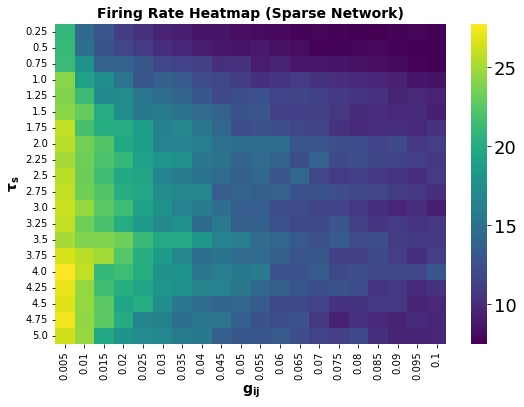

In [20]:
# Create results directory
os.makedirs("results", exist_ok=True)

# Define parameter grid
tau_s_values = np.linspace(0.25, 5, 20)
g_syn_values = np.linspace(0.005, 0.1, 20)
firing_rate_matrix = np.zeros((len(tau_s_values), len(g_syn_values)))

# File paths
progress_path = "results/firing_progress.json"
matrix_path = "results/firing_rate_matrix.npy"

# Load existing progress if available
completed = []
if os.path.exists(progress_path):
    with open(progress_path, "r") as f:
        completed = json.load(f)

if os.path.exists(matrix_path):
    firing_rate_matrix = np.load(matrix_path)

# Main simulation loop
for i, tau_s in enumerate(tau_s_values):
    for j, g_syn in enumerate(g_syn_values):
        if [i, j] in completed:
            continue  # Skip completed simulations

        # === Begin simulation setup ===
        g = np.zeros((N, N))
        for row in range(N):
            for col in range(N):
                if row != col and np.random.rand() < connection_probability:
                    g[row, col] = g_syn

        v_init = np.random.normal(-70, 5, size=(N))
        u_init = np.random.normal(-15, 0.5, size=(N))
        s_init = np.zeros(N)
        p_init = np.zeros(N)

        t_all = np.array([0])
        spike_times = np.zeros((M, 2))
        spikeCounter = 0
        t0 = 0
        i_step = 0

        while i_step < M and t0 < T:
            y0 = np.concatenate([v_init, u_init, s_init, p_init])
            sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tau_s),
                              dense_output=True, events=v_spike, rtol=1e-8)

            t_end = sol_v.t[-1]
            steps = max([2, int((t_end - t0) / dt)])
            t = np.linspace(t0, t_end, steps)
            y = sol_v.sol(t)

            t_all = np.concatenate([t_all, t[:-1]], axis=0)

            t0 = t_end
            v_init = y[:N, -1]
            u_init = y[N:2*N, -1]
            s_init = y[2*N:3*N, -1]
            p_init = y[3*N:4*N, -1]

            if len(sol_v.t_events[0]) > 0:
                spike = v_init.argmax()
                v_init[spike] = v_reset
                u_init[spike] += d
                p_init[spike] += (2.7185823035951033) / (tau_s / 3.043043043043043)

                spike_times[spikeCounter, :] = [t0, spike]
                spikeCounter += 1
                i_step += 1

        # === Compute firing rate ===
        valid_spike_times = spike_times[spike_times[:, 0] > 100]
        firing_rate = len(valid_spike_times) / (N * (T - 100)) * 1000  # spikes per second per neuron
        firing_rate_matrix[i, j] = firing_rate

        # Save partial result
        np.save(matrix_path, firing_rate_matrix)

        # Optional: save raw sim data
        np.savez(f"results/firing_sim_{i}_{j}.npz", spike_times=spike_times, tau_s=tau_s, g_syn=g_syn)

        # Log progress
        completed.append([i, j])
        with open(progress_path, "w") as f:
            json.dump(completed, f)

# === Plot final firing rate heatmap ===
plt.figure(figsize=(8, 6))
sns.heatmap(firing_rate_matrix, xticklabels=np.round(g_syn_values, 3), yticklabels=np.round(tau_s_values, 2), cmap='viridis')
plt.xlabel(r'$\mathbf{g_{ij}}$', fontsize=14, fontweight='bold')
plt.ylabel(r'$\mathbf{\tau_s}$', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Firing Rate Heatmap (Sparse Network)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('FiringRate_Sparse.png')
plt.show()

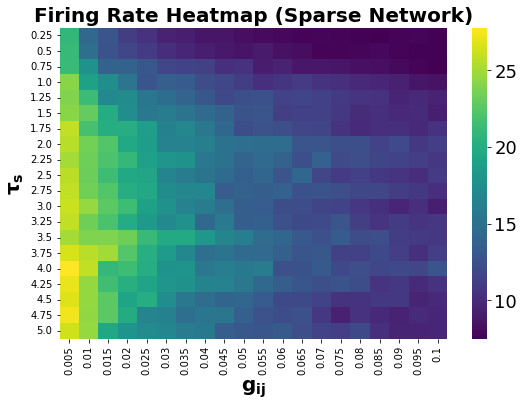

In [23]:
# === Plot final firing rate heatmap ===
plt.figure(figsize=(8, 6))
sns.heatmap(firing_rate_matrix, xticklabels=np.round(g_syn_values, 3), yticklabels=np.round(tau_s_values, 2), cmap='viridis')
plt.xlabel(r'$\mathbf{g_{ij}}$', fontsize=20, fontweight='bold')
plt.ylabel(r'$\mathbf{\tau_s}$', fontsize=20, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Firing Rate Heatmap (Sparse Network)', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig('FiringRate_Sparse.png')
plt.show()

# Reliability Colour Plot

In [ ]:
# Create results directory
os.makedirs("results", exist_ok=True)

# Define grid
tau_s_values = np.linspace(0.25, 5, 20)
g_syn_values = np.linspace(0.005, 0.1, 20)
reliability_matrix = np.zeros((len(tau_s_values), len(g_syn_values)))

# File paths
progress_path = "results/reliability_progress.json"
matrix_path = "results/reliability_matrix.npy"

# Load progress if available
completed = []
if os.path.exists(progress_path):
    with open(progress_path, "r") as f:
        completed = json.load(f)

if os.path.exists(matrix_path):
    reliability_matrix = np.load(matrix_path)

# Main loop
for i, tau_s in enumerate(tau_s_values):
    for j, g_syn in enumerate(g_syn_values):
        if [i, j] in completed:
            continue

        # Synaptic coupling matrix
        g = np.zeros((N, N))
        for row in range(N):
            for col in range(N):
                if row != col and np.random.rand() < connection_probability:
                    g[row, col] = g_syn

        # Initial conditions
        v_init = np.random.normal(-70, 5, size=(N))
        u_init = np.random.normal(-15, 0.5, size=(N))
        s_init = np.zeros(N)
        p_init = np.zeros(N)

        t0 = 0
        t_all = np.array([t0])
        y_0 = np.concatenate([v_init, u_init, s_init, p_init])
        y_all = np.reshape(y_0, (y_0.shape[0], 1))

        spike_matrix = np.zeros((N, int(T / dt)))
        spikeCounter = 0
        i_step = 0

        while i_step < M and t0 < T:
            y0 = np.concatenate([v_init, u_init, s_init, p_init])
            sol_v = solve_ivp(dxdt, [t0, T], y0,
                              args=(k, a, b, I, Esyn, J, tau_s),
                              dense_output=True, events=v_spike, rtol=1e-8)

            t_end = sol_v.t[-1]
            steps = max([2, int((t_end - t0) / dt)])
            t = np.linspace(t0, t_end, steps)
            y = sol_v.sol(t)

            t_all = np.concatenate([t_all, t[:-1]], axis=0)
            y_all = np.concatenate([y_all, y[:, :-1]], axis=1)

            t0 = t_end
            v_init = y[:N, -1]
            u_init = y[N:2*N, -1]
            s_init = y[2*N:3*N, -1]
            p_init = y[3*N:4*N, -1]

            if len(sol_v.t_events[0]) > 0:
                spike = v_init.argmax()
                v_init[spike] = v_reset
                u_init[spike] += d
                p_init[spike] += (2.7185823035951033) / (tau_s / 3.043043043043043)
                spike_col = int(t0 / dt)
                if spike_col < spike_matrix.shape[1]:
                    spike_matrix[spike, spike_col] = 1
                spikeCounter += 1
                i_step += 1

        # === Compute ISIs and t_R ===
        all_isis = []
        for neuron_id in range(N):
            spike_indices = np.where(spike_matrix[neuron_id, :] == 1)[0]
            if len(spike_indices) > 1:
                spike_times = spike_indices * dt
                isis = np.diff(spike_times)
                all_isis.extend(isis)

        all_isis = np.array(all_isis)
        if len(all_isis) == 0:
            t_R = 10.0
            print(f"Fallback t_R=10 used for tau_s={tau_s}, g_syn={g_syn}")
        else:
            hist_counts, hist_bins = np.histogram(all_isis, bins=100)
            max_bin_idx = np.argmax(hist_counts)
            bin_center = 0.5 * (hist_bins[max_bin_idx] + hist_bins[max_bin_idx + 1])
            t_R = bin_center / 2.0

        t_axis = np.linspace(0, T, spike_matrix.shape[1])
        reliability, _ = compute_Reliability(spike_matrix, t_axis, t_R)
        reliability_matrix[i, j] = reliability

        # Save matrix
        np.save(matrix_path, reliability_matrix)

        # Save raw data
        np.savez(f"results/reliability_sim_{i}_{j}.npz", spike_matrix=spike_matrix, tau_s=tau_s, g_syn=g_syn)

        # Save progress
        completed.append([i, j])
        with open(progress_path, "w") as f:
            json.dump(completed, f)

# === Final plot ===
plt.figure(figsize=(8, 6))
sns.heatmap(
    reliability_matrix,
    xticklabels=np.round(g_syn_values, 3),
    yticklabels=np.round(tau_s_values, 2),
    cmap='viridis'
)
plt.xlabel(r'$\mathbf{g_{ij}}$', fontsize=14, fontweight='bold')
plt.ylabel(r'$\mathbf{\tau_s}$', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Reliability Heatmap (Sparse Network)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('Reliability_Sparse.png')
plt.show()

# ISI Network Frequency Colour Plot

In [ ]:
# Create results directory
os.makedirs("results", exist_ok=True)

# Parameter grid
tau_s_values = np.linspace(0.25, 5, 20)
g_syn_values = np.linspace(0.005, 0.1, 20)
isi_freq_matrix = np.zeros((len(tau_s_values), len(g_syn_values)))

# File paths
progress_path = "results/isi_freq_progress.json"
matrix_path = "results/isi_freq_matrix.npy"

# Load progress if it exists
completed = []
if os.path.exists(progress_path):
    with open(progress_path, "r") as f:
        completed = json.load(f)

if os.path.exists(matrix_path):
    isi_freq_matrix = np.load(matrix_path)

# --- Begin parameter sweep ---
for i, tau_s in enumerate(tau_s_values):
    for j, g_syn in enumerate(g_syn_values):
        if [i, j] in completed:
            continue

        # Generate connectivity
        g = np.zeros((N, N))
        for row in range(N):
            for col in range(N):
                if row != col and np.random.rand() < connection_probability:
                    g[row, col] = g_syn

        # Initialize neuron states
        v_init = np.random.normal(-70, 15, size=N)
        u_init = np.random.normal(-15, 0.5, size=N)
        s_init = np.zeros(N)
        p_init = np.zeros(N)

        t0 = 0
        i_step = 0
        spikeCounter = 0
        spike_times = np.zeros((M, 2))

        # Simulate network
        while i_step < M and t0 < T:
            y0 = np.concatenate([v_init, u_init, s_init, p_init])
            sol_v = solve_ivp(
                dxdt, [t0, T], y0,
                args=(k, a, b, I, Esyn, J, tau_s),
                dense_output=True,
                events=v_spike,
                rtol=1e-8
            )

            t_end = sol_v.t[-1]
            steps = max([2, int((t_end - t0) / dt)])
            t_eval = np.linspace(t0, t_end, steps)
            y = sol_v.sol(t_eval)

            t0 = t_end
            v_init = y[:N, -1]
            u_init = y[N:2 * N, -1]
            s_init = y[2 * N:3 * N, -1]
            p_init = y[3 * N:4 * N, -1]

            if len(sol_v.t_events[0]) > 0:
                spike = v_init.argmax()
                v_init[spike] = v_reset
                u_init[spike] += d
                p_init[spike] += (2.7185823035951033)/(tau_s / 3.043043043043043)
                spike_times[spikeCounter, :] = [t0, spike]
                spikeCounter += 1
                i_step += 1

        # --- Process ISIs ---
        neuron_spike_times = {n: [] for n in range(N)}
        for idx in range(spikeCounter):
            time, neuron = spike_times[idx]
            neuron_spike_times[int(neuron)].append(time)

        interspike_intervals = []
        for times in neuron_spike_times.values():
            times = sorted(times)
            if len(times) > 1:
                isis = np.diff(times)
                interspike_intervals.extend(isis)

        interspike_intervals = [isi for isi in interspike_intervals if isi > 0]

        if interspike_intervals:
            frequencies, bin_edges = np.histogram(interspike_intervals, bins=100)
            max_freq_idx = np.argmax(frequencies)
            most_common_isi = 0.5 * (bin_edges[max_freq_idx] + bin_edges[max_freq_idx + 1])
            firing_rate_hz = 1000.0 / most_common_isi
        else:
            firing_rate_hz = 0.0

        isi_freq_matrix[i, j] = firing_rate_hz

        # Save progress
        np.save(matrix_path, isi_freq_matrix)
        np.savez(f"results/isi_sim_{i}_{j}.npz", spike_times=spike_times, tau_s=tau_s, g_syn=g_syn)
        completed.append([i, j])
        with open(progress_path, "w") as f:
            json.dump(completed, f)

# --- Plot the heatmap ---
plt.figure(figsize=(8, 6))
sns.heatmap(
    isi_freq_matrix,
    xticklabels=np.round(g_syn_values, 3),
    yticklabels=np.round(tau_s_values, 2),
    cmap='plasma'
)
plt.xlabel(r'$\mathbf{g_{ij}}$', fontsize=14, fontweight='bold')
plt.ylabel(r'$\mathbf{\tau_s}$', fontsize=14, fontweight='bold')
plt.title("Network Frequency Heatmap (Sparse Network)", fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('Network_Frequency_Sparse.png')
plt.show()

# All-to-all Network Colour Plots

In [ ]:
# A2A
np.random.seed(101)

N = 300
T = 300
M = 50000
dt = 0.005
t0 = 0

k = 1
a = 0.1
b = 0.26
c = -65
d = -1
v_reset = c
v_thresh = 30

Esyn = -70
tauS = 3.043043043043043 # Obtained from having peaks of coupling in paper and in ours aligned

J = np.random.normal(0, 0.1, size=(N))


I = 0.6

# Define desired average number of connections
Avg_Connections = 40
connection_probability = Avg_Connections / N

# Initialize the synaptic coupling matrix
g = np.zeros((N, N))

# Initialize the matrix with the desired value
g = np.full((N, N), 0.00397291)

# Set the diagonal elements to zero
np.fill_diagonal(g, 0)

v_init = np.random.normal(-70, 5, size=(N))
u_init = np.random.normal(-15, 0.5, size = (N)) # Ask any reason why these were chosen and not ones in page 3 paper
s_init = np.zeros(N)
p_init = np.zeros(N)

t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init, s_init, p_init])
y_all = np.reshape(y_0, (y_0.shape[0], 1))

spike_times = np.zeros((M, 2))
spikeCounter = 0
i = 0

def dxdt(t, x, k, a, b, I, Esyn, J, tauS):
    v = x[:N]
    u = x[N:2*N]
    s = x[2*N:3*N]
    p = x[3*N:4*N]
    
    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) + J - (v - Esyn) * np.dot(g,s)
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS + p / tauS
    dpdt = -p / tauS
    
    return np.concatenate([dvdt, dudt, dsdt, dpdt])

# Spike event
def v_spike(t, x, k, a, b, I, Esyn, J, tauS):
    return x[:N].max() - v_thresh
v_spike.terminal = True
v_spike.direction = 1

# Set up spike time vector
spike_times = np.zeros((M, 2))
spikeCounter = 0    
i = 0

# Simulation loop
while i < M and t0 < T:
    y0 = np.concatenate([v_init, u_init, s_init, p_init])  
   
    sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                      events=v_spike, rtol=1e-8)
    
    t_end = sol_v.t[-1]
    steps = max([2, int((t_end - t0) / dt)])
    t = np.linspace(t0, t_end, steps)
    y = sol_v.sol(t)
    
    t_all = np.concatenate([t_all, t[:-1]], axis=0)
    y_all = np.concatenate([y_all, y[:, :-1]], axis=1)
    
    t0 = t_end
    v_init = y[:N, -1]
    u_init = y[N:2*N, -1]
    s_init = y[2*N:3*N, -1]
    p_init = y[3*N:4*N, -1]
    
    if len(sol_v.t_events[0]) > 0:
        spike = v_init.argmax()
        v_init[spike] = v_reset
        u_init[spike] += d
        p_init[spike] += (2.7185823035951033)/(tauS/3.043043043043043) #x0 
        
        
        spike_times[spikeCounter, :] = [t0, spike]
        spikeCounter = spikeCounter + 1
        i += 1

colours = sns.color_palette('deep')
font = {'family': 'Times', 'weight': 'normal', 'size': 18}
plt.rc('font', **font)

# Plot 1: Neuron Simulation
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[:N, :].T, linewidth=2)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Voltage (mV)', fontsize=14, fontweight='bold')
plt.title('Neuron Simulation', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig('NeuronModel_A2A.png')

# Plot 2: Mean Voltage Over Time
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[:N, :].mean(axis=0), linewidth=2)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Mean Voltage (mV)', fontsize=14, fontweight='bold')
plt.title('Mean Voltage Over Time', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig('MeanVoltage_A2A.png')

# Plot 3: Spike Times Scatter Plot
spike_times = spike_times[:spikeCounter, :]
plt.figure(figsize=(8, 6))
plt.scatter(spike_times[:, 0], spike_times[:, 1], color='blue', alpha=0.6)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Neuron', fontsize=14, fontweight='bold')
plt.title('Spike Times', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig('SpikeTimes_A2A.png')

# Plot 4: Recovery Variable
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[N:2*N, :].T, linewidth=2, alpha=0.8)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Recovery Variable', fontsize=14, fontweight='bold')
plt.title('Recovery Variable Over Time', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig('RecoveryVariable_A2A.png')




# Count the number of non-zero entries in each row
connections_per_neuron = np.count_nonzero(g, axis=1)

# Calculate the average number of connections per neuron
average_connections = np.mean(connections_per_neuron)

print(f"Average number of connections per neuron: {average_connections}")
print("Connectivity Matrix g", g)
print("Average value of matrix g=", np.mean(g))
# Extract the voltage traces (first N rows of y_all)
voltage_data = y_all[:N, :]  # Shape: (N, time_steps)

# Compute the Chi measure
chi_value = compute_chi(voltage_data)

# Print the Chi measure
print(f"Chi measure (synchrony): {chi_value}")


average_firing_rate = len(spike_times[spike_times[:, 0] > 100]) / (N * (T - 100))*1000
print("Average firing rate", average_firing_rate)

# $\chi^2$ Colour Plot

In [ ]:
g_syn_values = np.linspace(0.005, 0.1, 20)  
print(g_syn_values)
tau_s_values = np.linspace(0.25, 5, 20)
print(tau_s_values)

In [ ]:
# Create results directory
os.makedirs("results", exist_ok=True)

# Parameter grid
tau_s_values = np.linspace(0.25, 5, 20)
g_syn_values = np.linspace(0.005, 0.1, 20)
chi_sq_matrix_A2A = np.zeros((len(tau_s_values), len(g_syn_values)))

# File paths
progress_path = "results/chi_A2A_progress.json"
matrix_path = "results/chi_sq_matrix_A2A.npy"

# Load previous progress if it exists
completed = []
if os.path.exists(progress_path):
    with open(progress_path, "r") as f:
        completed = json.load(f)

if os.path.exists(matrix_path):
    chi_sq_matrix_A2A = np.load(matrix_path)

# Sweep through parameters
for i, tau_s in enumerate(tau_s_values):
    for j, g_syn in enumerate(g_syn_values):
        if [i, j] in completed:
            continue  # skip already completed

        # --- All-to-All Connectivity Matrix ---
        p = connection_probability
        g = np.full((N, N), p * g_syn)
        np.fill_diagonal(g, 0.0)  # no self-connections

        # Initialize neuron states
        v_init = np.random.normal(-70, 15, size=(N))
        u_init = np.random.normal(-15, 0.5, size=(N))
        s_init = np.zeros(N)
        p_init = np.zeros(N)

        t0 = 0
        spike_times = np.zeros((M, 2))
        spikeCounter = 0
        i_step = 0
        t_all = np.array([t0])
        y_0 = np.concatenate([v_init, u_init, s_init, p_init])
        y_all = np.reshape(y_0, (y_0.shape[0], 1))

        # --- Simulation loop ---
        while i_step < M and t0 < T:
            y0 = np.concatenate([v_init, u_init, s_init, p_init])
            sol_v = solve_ivp(
                dxdt, [t0, T], y0,
                args=(k, a, b, I, Esyn, J, tau_s),
                dense_output=True,
                events=v_spike,
                rtol=1e-8
            )

            t_end = sol_v.t[-1]
            steps = max([2, int((t_end - t0) / dt)])
            t = np.linspace(t0, t_end, steps)
            y = sol_v.sol(t)

            t_all = np.concatenate([t_all, t[:-1]], axis=0)
            y_all = np.concatenate([y_all, y[:, :-1]], axis=1)

            t0 = t_end
            v_init = y[:N, -1]
            u_init = y[N:2*N, -1]
            s_init = y[2*N:3*N, -1]
            p_init = y[3*N:4*N, -1]

            if len(sol_v.t_events[0]) > 0:
                spike = v_init.argmax()
                v_init[spike] = v_reset
                u_init[spike] += d
                p_init[spike] += (2.7185823035951033)/(tau_s / 3.043043043043043)
                spike_times[spikeCounter, :] = [t0, spike]
                spikeCounter += 1
                i_step += 1

        # --- Compute chi-squared ---
        data = y_all[:N, :]
        chi_sq_A2A = compute_chi(data)
        chi_sq_matrix_A2A[i, j] = chi_sq_A2A

        # Save matrix
        np.save(matrix_path, chi_sq_matrix_A2A)

        # Optional: Save raw data
        np.savez(f"results/chi_A2A_sim_{i}_{j}.npz", t_all=t_all, y_all=y_all, spike_times=spike_times)

        # Save progress
        completed.append([i, j])
        with open(progress_path, "w") as f:
            json.dump(completed, f)

# --- Plot final heatmap ---
plt.figure(figsize=(8, 6))
sns.heatmap(
    chi_sq_matrix_A2A,
    xticklabels=np.round(g_syn_values, 3),
    yticklabels=np.round(tau_s_values, 2),
    cmap='viridis'
)
plt.xlabel(r'$\mathbf{g_{ij}}$', fontsize=14, fontweight='bold')
plt.ylabel(r'$\mathbf{\tau_s}$', fontsize=14, fontweight='bold')
plt.title(r'$\mathbf{\chi^2}$ Heatmap (All-to-All Network)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('Chi_A2A.png')
plt.show()

# Firing Rate Heatmap

In [ ]:
# Create results directory
os.makedirs("results", exist_ok=True)

# Parameter grid
tau_s_values = np.linspace(0.25, 5, 20)
g_syn_values = np.linspace(0.005, 0.1, 20)
firing_rate_matrix_A2A = np.zeros((len(tau_s_values), len(g_syn_values)))

# File paths
progress_path = "results/firing_A2A_progress.json"
matrix_path = "results/firing_rate_matrix_A2A.npy"

# Load progress if it exists
completed = []
if os.path.exists(progress_path):
    with open(progress_path, "r") as f:
        completed = json.load(f)

if os.path.exists(matrix_path):
    firing_rate_matrix_A2A = np.load(matrix_path)

# Begin simulation
for i, tau_s in enumerate(tau_s_values):
    for j, g_syn in enumerate(g_syn_values):
        if [i, j] in completed:
            continue  # skip completed

        # All-to-All Connectivity: each off-diagonal entry = p * g_syn
        p = connection_probability
        g = np.full((N, N), p * g_syn)
        np.fill_diagonal(g, 0.0)  # no self-connections

        # Initialize neuron states
        v_init = np.random.normal(-70, 5, size=(N))
        u_init = np.random.normal(-15, 0.5, size=(N))
        s_init = np.zeros(N)
        p_init = np.zeros(N)

        t_all = np.array([0])
        spike_times = np.zeros((M, 2))
        spikeCounter = 0
        t0 = 0
        i_step = 0

        while i_step < M and t0 < T:
            y0 = np.concatenate([v_init, u_init, s_init, p_init])

            sol_v = solve_ivp(dxdt, [t0, T], y0,
                              args=(k, a, b, I, Esyn, J, tau_s),
                              dense_output=True, events=v_spike,
                              rtol=1e-8)

            t_end = sol_v.t[-1]
            steps = max([2, int((t_end - t0) / dt)])
            t = np.linspace(t0, t_end, steps)
            y = sol_v.sol(t)

            t_all = np.concatenate([t_all, t[:-1]], axis=0)

            t0 = t_end
            v_init = y[:N, -1]
            u_init = y[N:2*N, -1]
            s_init = y[2*N:3*N, -1]
            p_init = y[3*N:4*N, -1]

            if len(sol_v.t_events[0]) > 0:
                spike = v_init.argmax()
                v_init[spike] = v_reset
                u_init[spike] += d
                p_init[spike] += (2.7185823035951033)/(tau_s / 3.043043043043043)

                spike_times[spikeCounter, :] = [t0, spike]
                spikeCounter += 1
                i_step += 1

        # Compute average firing rate (after 100 ms warmup)
        valid_spike_times = spike_times[spike_times[:, 0] > 100]
        firing_rate_A2A = len(valid_spike_times) / (N * (T - 100)) * 1000
        firing_rate_matrix_A2A[i, j] = firing_rate_A2A

        # Save matrix
        np.save(matrix_path, firing_rate_matrix_A2A)

        # Save raw sim data
        np.savez(f"results/firing_A2A_sim_{i}_{j}.npz", spike_times=spike_times, tau_s=tau_s, g_syn=g_syn)

        # Save progress
        completed.append([i, j])
        with open(progress_path, "w") as f:
            json.dump(completed, f)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(
    firing_rate_matrix_A2A,
    xticklabels=np.round(g_syn_values, 3),
    yticklabels=np.round(tau_s_values, 2),
    cmap='viridis'
)
plt.xlabel(r'$\mathbf{g_{ij}}$', fontsize=14, fontweight='bold')
plt.ylabel(r'$\mathbf{\tau_s}$', fontsize=14, fontweight='bold')
plt.title('Firing Rate Heatmap (All-to-All Network)', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('FiringRate_A2A.png')
plt.show()

# Reliability Colour Plot

In [ ]:
# Create results directory
os.makedirs("results", exist_ok=True)

# Parameter grid
tau_s_values = np.linspace(0.25, 5, 20)
g_syn_values = np.linspace(0.005, 0.1, 20)
reliability_matrix_A2A = np.zeros((len(tau_s_values), len(g_syn_values)))

# File paths
progress_path = "results/reliability_A2A_progress.json"
matrix_path = "results/reliability_matrix_A2A.npy"

# Load progress if exists
completed = []
if os.path.exists(progress_path):
    with open(progress_path, "r") as f:
        completed = json.load(f)

if os.path.exists(matrix_path):
    reliability_matrix_A2A = np.load(matrix_path)

# Main loop
for i, tau_s in enumerate(tau_s_values):
    for j, g_syn in enumerate(g_syn_values):
        if [i, j] in completed:
            continue

        p = connection_probability
        g = np.full((N, N), p * g_syn)
        np.fill_diagonal(g, 0.0)

        v_init = np.random.normal(-70, 5, size=(N))
        u_init = np.random.normal(-15, 0.5, size=(N))
        s_init = np.zeros(N)
        p_init = np.zeros(N)

        t0 = 0
        spike_matrix = np.zeros((N, int(T / dt)))
        spikeCounter = 0
        i_step = 0
        t_all = np.array([t0])
        y_0 = np.concatenate([v_init, u_init, s_init, p_init])
        y_all = np.reshape(y_0, (y_0.shape[0], 1))

        while i_step < M and t0 < T:
            y0 = np.concatenate([v_init, u_init, s_init, p_init])
            sol_v = solve_ivp(
                dxdt, [t0, T], y0,
                args=(k, a, b, I, Esyn, J, tau_s),
                dense_output=True,
                events=v_spike,
                rtol=1e-8
            )

            t_end = sol_v.t[-1]
            steps = max([2, int((t_end - t0) / dt)])
            t = np.linspace(t0, t_end, steps)
            y = sol_v.sol(t)

            t_all = np.concatenate([t_all, t[:-1]], axis=0)
            y_all = np.concatenate([y_all, y[:, :-1]], axis=1)

            t0 = t_end
            v_init = y[:N, -1]
            u_init = y[N:2*N, -1]
            s_init = y[2*N:3*N, -1]
            p_init = y[3*N:4*N, -1]

            if len(sol_v.t_events[0]) > 0:
                spike = v_init.argmax()
                v_init[spike] = v_reset
                u_init[spike] += d
                p_init[spike] += (2.7185823035951033) / (tau_s / 3.043043043043043)

                spike_col = int(t0 / dt)
                if spike_col < spike_matrix.shape[1]:
                    spike_matrix[spike, spike_col] = 1

                spikeCounter += 1
                i_step += 1

        # --- Compute ISI-based t_R ---
        all_isis = []
        for neuron_id in range(N):
            spike_indices = np.where(spike_matrix[neuron_id, :] == 1)[0]
            if len(spike_indices) > 1:
                spike_times = spike_indices * dt
                isis = np.diff(spike_times)
                all_isis.extend(isis)

        all_isis = np.array(all_isis)

        if len(all_isis) == 0:
            t_R = 10.0
            print(f"Fallback t_R=10 used for tau_s={tau_s}, g_syn={g_syn}")
        else:
            hist_counts, hist_bins = np.histogram(all_isis, bins=100)
            max_bin_idx = np.argmax(hist_counts)
            bin_center = 0.5 * (hist_bins[max_bin_idx] + hist_bins[max_bin_idx + 1])
            t_R = bin_center / 2.0

        t_axis = np.linspace(0, T, spike_matrix.shape[1])
        reliability, _ = compute_Reliability(spike_matrix, t_axis, t_R)
        reliability_matrix_A2A[i, j] = reliability

        # Save matrix
        np.save(matrix_path, reliability_matrix_A2A)

        # Save raw data
        np.savez(f"results/reliability_A2A_sim_{i}_{j}.npz",
                 spike_matrix=spike_matrix, tau_s=tau_s, g_syn=g_syn)

        # Update progress
        completed.append([i, j])
        with open(progress_path, "w") as f:
            json.dump(completed, f)

# --- Plot the heatmap ---
plt.figure(figsize=(8, 6))
sns.heatmap(
    reliability_matrix_A2A,
    xticklabels=np.round(g_syn_values, 3),
    yticklabels=np.round(tau_s_values, 2),
    cmap='viridis'
)
plt.xlabel(r'$\mathbf{g_{ij}}$', fontsize=14, fontweight='bold')
plt.ylabel(r'$\mathbf{\tau_s}$', fontsize=14, fontweight='bold')
plt.title('Reliability Heatmap (All-to-All Network)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('Reliability_A2A.png')
plt.show()


# ISI Firing Rate Colour Plot

In [ ]:
# Create results directory
os.makedirs("results", exist_ok=True)

# Parameter grid
tau_s_values = np.linspace(0.25, 5, 20)
g_syn_values = np.linspace(0.005, 0.1, 20)
isi_freq_matrix_A2A = np.zeros((len(tau_s_values), len(g_syn_values)))

# File paths
progress_path = "results/isi_freq_A2A_progress.json"
matrix_path = "results/isi_freq_matrix_A2A.npy"

# Load existing progress
completed = []
if os.path.exists(progress_path):
    with open(progress_path, "r") as f:
        completed = json.load(f)

if os.path.exists(matrix_path):
    isi_freq_matrix_A2A = np.load(matrix_path)

# Begin sweep
for i, tau_s in enumerate(tau_s_values):
    for j, g_syn in enumerate(g_syn_values):
        if [i, j] in completed:
            continue

        # All-to-All connectivity matrix
        p = connection_probability
        g = np.full((N, N), p * g_syn)
        np.fill_diagonal(g, 0.0)

        # Initial conditions
        v_init = np.random.normal(-70, 15, size=N)
        u_init = np.random.normal(-15, 0.5, size=N)
        s_init = np.zeros(N)
        p_init = np.zeros(N)

        t0 = 0
        i_step = 0
        spikeCounter = 0
        spike_times = np.zeros((M, 2))

        # Simulation loop
        while i_step < M and t0 < T:
            y0 = np.concatenate([v_init, u_init, s_init, p_init])
            sol_v = solve_ivp(
                dxdt, [t0, T], y0,
                args=(k, a, b, I, Esyn, J, tau_s),
                dense_output=True,
                events=v_spike,
                rtol=1e-8
            )

            t_end = sol_v.t[-1]
            steps = max([2, int((t_end - t0) / dt)])
            t_eval = np.linspace(t0, t_end, steps)
            y = sol_v.sol(t_eval)

            t0 = t_end
            v_init = y[:N, -1]
            u_init = y[N:2 * N, -1]
            s_init = y[2 * N:3 * N, -1]
            p_init = y[3 * N:4 * N, -1]

            if len(sol_v.t_events[0]) > 0:
                spike = v_init.argmax()
                v_init[spike] = v_reset
                u_init[spike] += d
                p_init[spike] += (2.7185823035951033)/(tau_s / 3.043043043043043)

                spike_times[spikeCounter, :] = [t0, spike]
                spikeCounter += 1
                i_step += 1

        # Process ISIs
        neuron_spike_times = {n: [] for n in range(N)}
        for idx in range(spikeCounter):
            time, neuron = spike_times[idx]
            neuron_spike_times[int(neuron)].append(time)

        interspike_intervals = []
        for times in neuron_spike_times.values():
            times = sorted(times)
            if len(times) > 1:
                isis = np.diff(times)
                interspike_intervals.extend(isis)

        interspike_intervals = [isi for isi in interspike_intervals if isi > 0]

        if interspike_intervals:
            frequencies, bin_edges = np.histogram(interspike_intervals, bins=100)
            max_freq_idx = np.argmax(frequencies)
            most_common_isi = 0.5 * (bin_edges[max_freq_idx] + bin_edges[max_freq_idx + 1])
            firing_rate_hz = 1000.0 / most_common_isi
        else:
            firing_rate_hz = 0.0

        isi_freq_matrix_A2A[i, j] = firing_rate_hz

        # Save matrix
        np.save(matrix_path, isi_freq_matrix_A2A)

        # Save simulation data (optional)
        np.savez(f"results/isi_freq_A2A_sim_{i}_{j}.npz", spike_times=spike_times, tau_s=tau_s, g_syn=g_syn)

        # Update progress
        completed.append([i, j])
        with open(progress_path, "w") as f:
            json.dump(completed, f)

# --- Plot heatmap ---
plt.figure(figsize=(8, 6))
sns.heatmap(
    isi_freq_matrix_A2A,
    xticklabels=np.round(g_syn_values, 3),
    yticklabels=np.round(tau_s_values, 2),
    cmap='plasma'
)
plt.xlabel(r'$\mathbf{g_{ij}}$', fontsize=14, fontweight='bold')
plt.ylabel(r'$\mathbf{\tau_s}$', fontsize=14, fontweight='bold')
plt.title("Network Frequency Heatmap (All-to-All Network)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('Firing_Rate_Heatmap_Mode_ISI_A2A.png')
plt.show()